In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

df = pd.read_csv('healthcare_dataset.csv')

In [3]:
# Data Cleaning
# Standardize text columns
df['Gender'] = df['Gender'].str.title()
df['Admission Type'] = df['Admission Type'].str.title()
df['Medical Condition'] = df['Medical Condition'].str.title()

# Handle negative billing
df['Billing Amount'] = df['Billing Amount'].abs()

# Convert dates
df['Date of Admission'] = pd.to_datetime(df['Date of Admission'])
df['Discharge Date'] = pd.to_datetime(df['Discharge Date'])

In [4]:
# Calculate length of stay
df['Length of Stay'] = (df['Discharge Date'] - df['Date of Admission']).dt.days

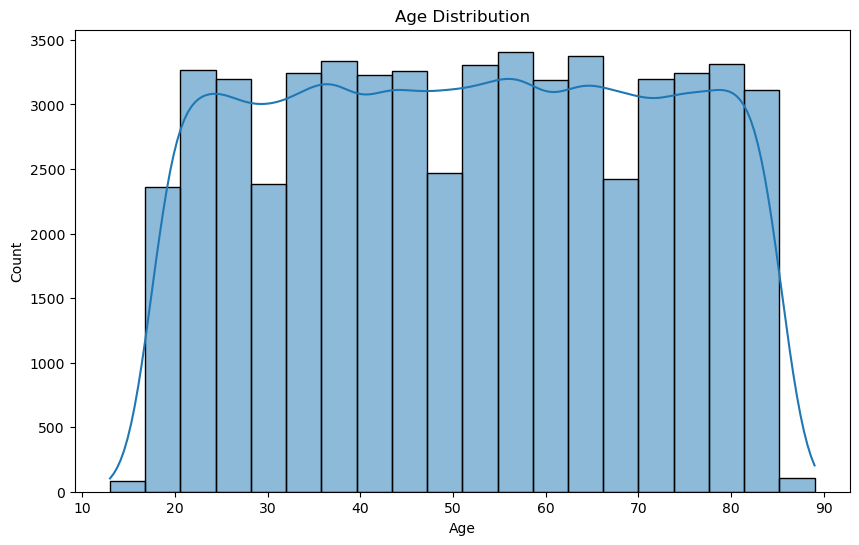

In [5]:
# Demographic Analysis
plt.figure(figsize=(10,6))
sns.histplot(df['Age'], bins=20, kde=True)
plt.title('Age Distribution')
plt.show()

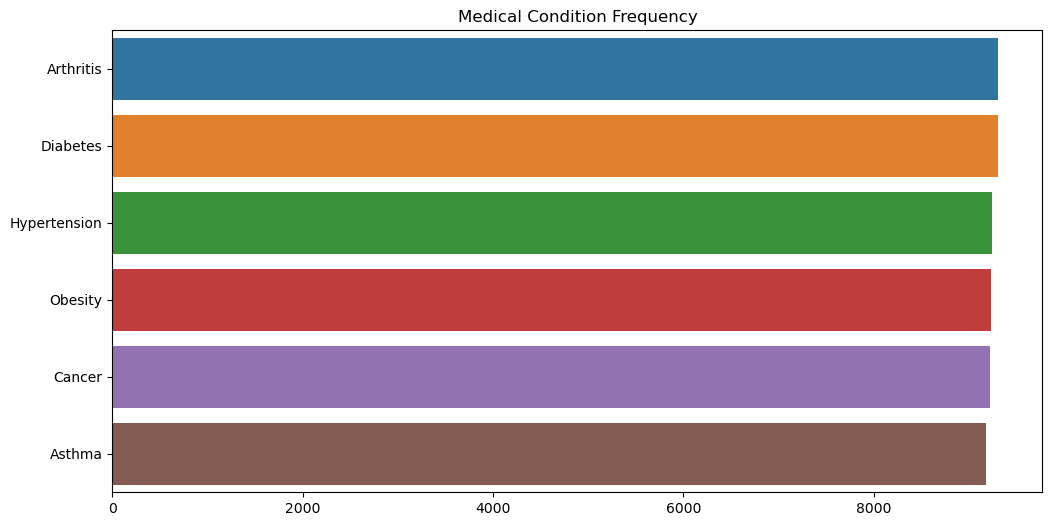

In [6]:
# Medical Condition Distribution
condition_counts = df['Medical Condition'].value_counts()
plt.figure(figsize=(12,6))
sns.barplot(x=condition_counts.values, y=condition_counts.index)
plt.title('Medical Condition Frequency')
plt.show()

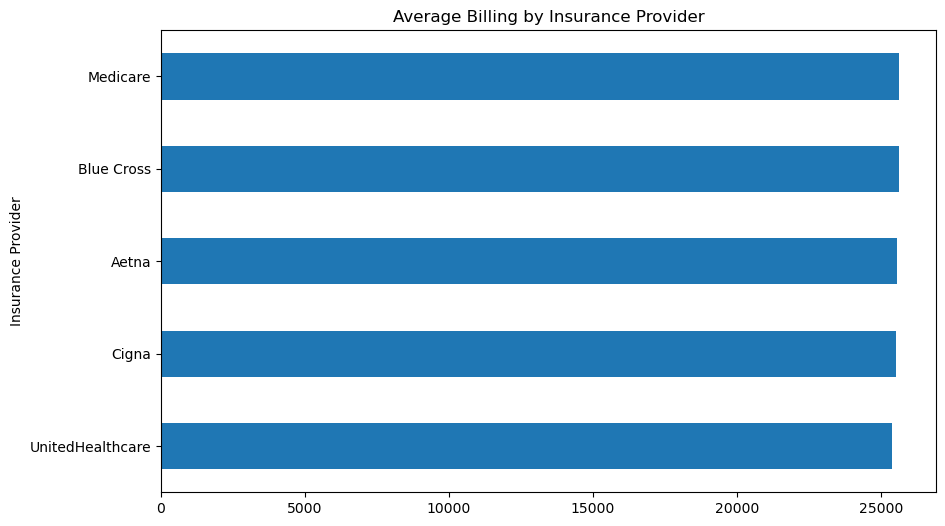

In [7]:
# Insurance Analysis
insurance_billing = df.groupby('Insurance Provider')['Billing Amount'].mean()
plt.figure(figsize=(10,6))
insurance_billing.sort_values().plot(kind='barh')
plt.title('Average Billing by Insurance Provider')
plt.show()

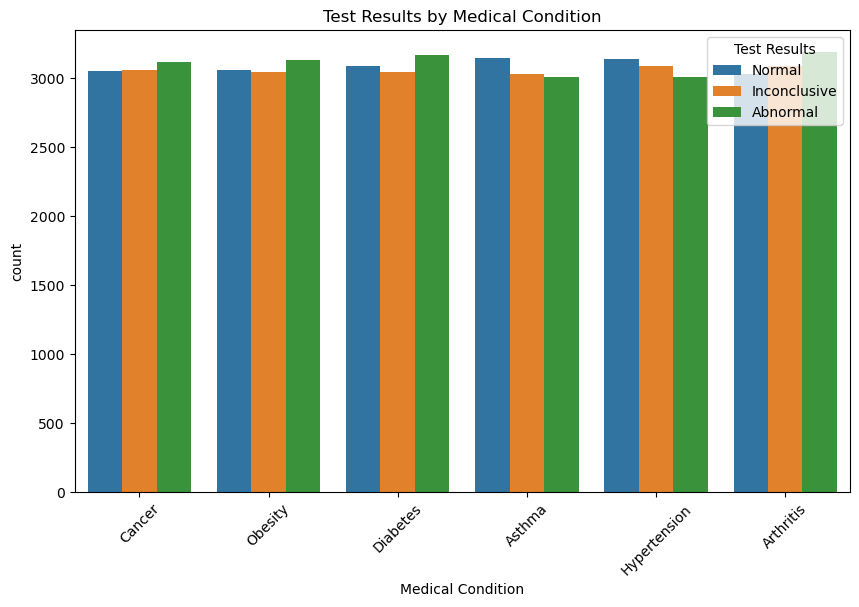

In [8]:
# Test Result Correlation
plt.figure(figsize=(10,6))
sns.countplot(data=df, x='Medical Condition', hue='Test Results')
plt.xticks(rotation=45)
plt.title('Test Results by Medical Condition')
plt.show()

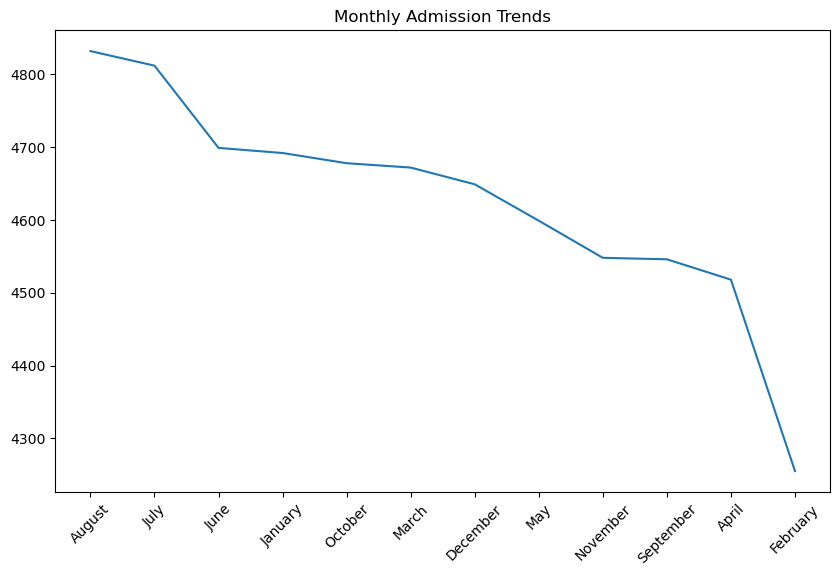

In [9]:
# Temporal Analysis
df['Admission Month'] = df['Date of Admission'].dt.month_name()
monthly_admissions = df['Admission Month'].value_counts()
plt.figure(figsize=(10,6))
sns.lineplot(x=monthly_admissions.index, y=monthly_admissions.values)
plt.title('Monthly Admission Trends')
plt.xticks(rotation=45)
plt.show()

In [10]:
# Export cleaned data
df.to_csv('cleaned_healthcare_data.csv', index=False)

Patient Segmentation Clustering

In [11]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [12]:
# Prepare data
cluster_df = df[['Age', 'Billing Amount', 'Length of Stay', 'Room Number']]
cluster_df = pd.get_dummies(df[['Gender', 'Blood Type', 'Medical Condition']])

# Normalize
scaler = StandardScaler()
scaled_data = scaler.fit_transform(cluster_df)

/Users/gaoshan/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/gaoshan/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/gaoshan/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/gaoshan/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will chang

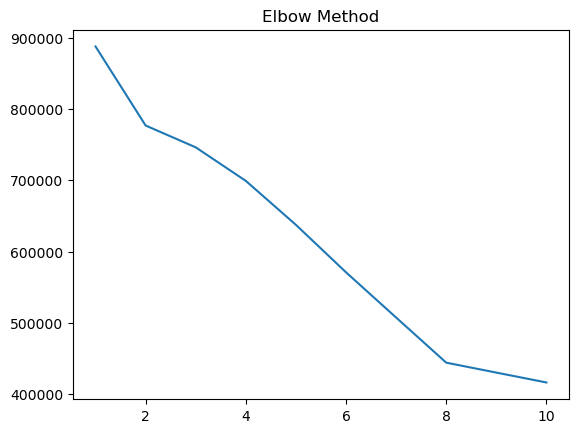

In [13]:
# Determine optimal clusters
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(scaled_data)
    wcss.append(kmeans.inertia_)
plt.plot(range(1,11), wcss)
plt.title('Elbow Method')
plt.show()


In [14]:
# Apply K-means
kmeans = KMeans(n_clusters=4, init='k-means++', random_state=42)
clusters = kmeans.fit_predict(scaled_data)

/Users/gaoshan/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


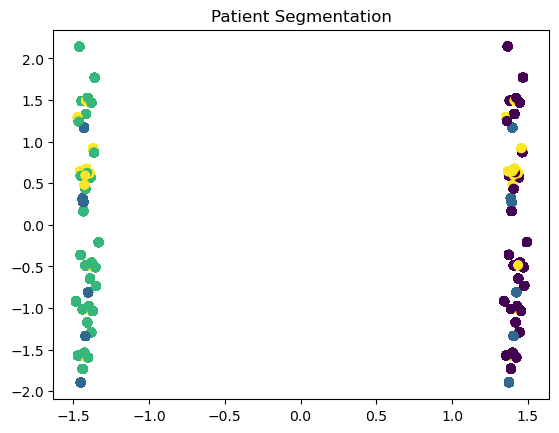

In [15]:
# Visualize with PCA
pca = PCA(n_components=2)
principal_components = pca.fit_transform(scaled_data)
plt.scatter(principal_components[:,0], principal_components[:,1], c=clusters)
plt.title('Patient Segmentation')
plt.show()

Readmission Risk Scoring System (Binary Classification)

In [16]:
# Create readmission target (example: readmitted if same doctor within 30 days)
df = df.sort_values(['Name', 'Date of Admission'])
df['Next Admission'] = df.groupby('Name')['Date of Admission'].shift(-1)
df['Readmission'] = (df['Next Admission'] - df['Discharge Date']).dt.days <= 30
df['Readmission'] = df['Readmission'].fillna(False).astype(int)

In [17]:
# Features and target
X = df.drop(['Readmission', 'Next Admission', 'Name', 'Date of Admission', 'Discharge Date'], axis=1)
y = df['Readmission']

In [19]:
pip install xgboost

  Obtaining dependency information for xgboost from https://files.pythonhosted.org/packages/5a/0b/f9f815f240a9610d42367172b9f7ef7e8c9113a09b1bb35d4d85f96b910a/xgboost-3.0.0-py3-none-macosx_12_0_arm64.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 23.1 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.


In [23]:
# Pipeline with XGBoost
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
categorical_features = ['Gender', 'Blood Type', 'Medical Condition', 
                       'Doctor', 'Hospital', 'Insurance Provider',
                       'Admission Type', 'Medication']
numerical_features = ['Age', 'Billing Amount', 'Room Number', 'Length of Stay']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)]
)


model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(scale_pos_weight=len(y[y==0])/len(y[y==1])))
])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Age', 'Billing Amount',
                                                   'Room Number',
                                                   'Length of Stay']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Gender', 'Blood Type',
                                                   'Medical Condition',
                                                   'Doctor', 'Hospital',
                                                   'Insurance Provider',
                                                   'Admission Type',
                                                   'Medication'])])),
                ('classifier',
                 XGBClassifier(base_score=None, boos...
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, ...))])

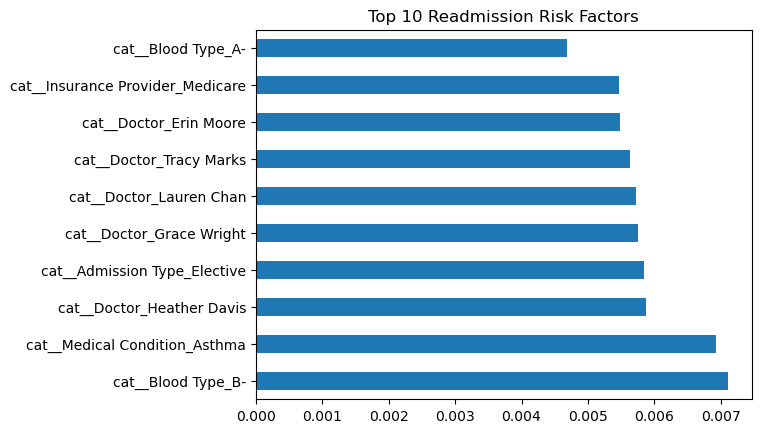

In [25]:
# Feature importance
importances = model.named_steps['classifier'].feature_importances_
features = model.named_steps['preprocessor'].get_feature_names_out()
pd.Series(importances, index=features).sort_values(ascending=False).head(10).plot(kind='barh')
plt.title('Top 10 Readmission Risk Factors')
plt.show()

Doctor Performance Analysis

In [26]:
# Create performance metrics
doctor_stats = df.groupby('Doctor').agg({
    'Billing Amount': 'mean',
    'Test Results': lambda x: (x == 'Normal').mean(),
    'Length of Stay': 'median',
    'Readmission': 'mean',
    'Name': 'count'
}).rename(columns={'Name': 'Patient Count'})

In [27]:
# Normalize metrics
doctor_stats['Performance Score'] = (
    0.4 * (1 - doctor_stats['Readmission']) +
    0.3 * doctor_stats['Test Results'] +
    0.2 * (1 / doctor_stats['Length of Stay']) +
    0.1 * (1 / doctor_stats['Billing Amount'])
)

In [28]:
# Top 10 doctors
doctor_stats.sort_values('Performance Score', ascending=False).head(10).style.background_gradient()

,Billing Amount,Test Results,Length of Stay,Readmission,Patient Count,Performance Score
Doctor,,,,,,
Jesse Cervantes,172.613392,1.000000,1.000000,0.000000,1,0.900579
Stephen Stokes,695.733635,1.000000,1.000000,0.000000,1,0.900144
Wanda Bryant,1222.152056,1.000000,1.000000,0.000000,1,0.900082
Richard Wilcox,1299.118219,1.000000,1.000000,0.000000,1,0.900077
Willie Blake,1638.277998,1.000000,1.000000,0.000000,1,0.900061
Lisa Richard,1858.519099,1.000000,1.000000,0.000000,1,0.900054
Julia Shelton,2036.377712,1.000000,1.000000,0.000000,1,0.900049
Amy Greer,2142.956280,1.000000,1.000000,0.000000,1,0.900047
Sarah Carter,2257.090196,1.000000,1.000000,0.000000,1,0.900044


Cost-Effectiveness Analysis

In [29]:
# Group by medical condition and medication
cost_effectiveness = df.groupby(['Medical Condition', 'Medication']).agg({
    'Billing Amount': 'mean',
    'Test Results': lambda x: (x == 'Normal').mean()
}).reset_index()

In [30]:
# Calculate cost-effectiveness ratio
cost_effectiveness['Cost per Success'] = cost_effectiveness['Billing Amount'] / cost_effectiveness['Test Results']

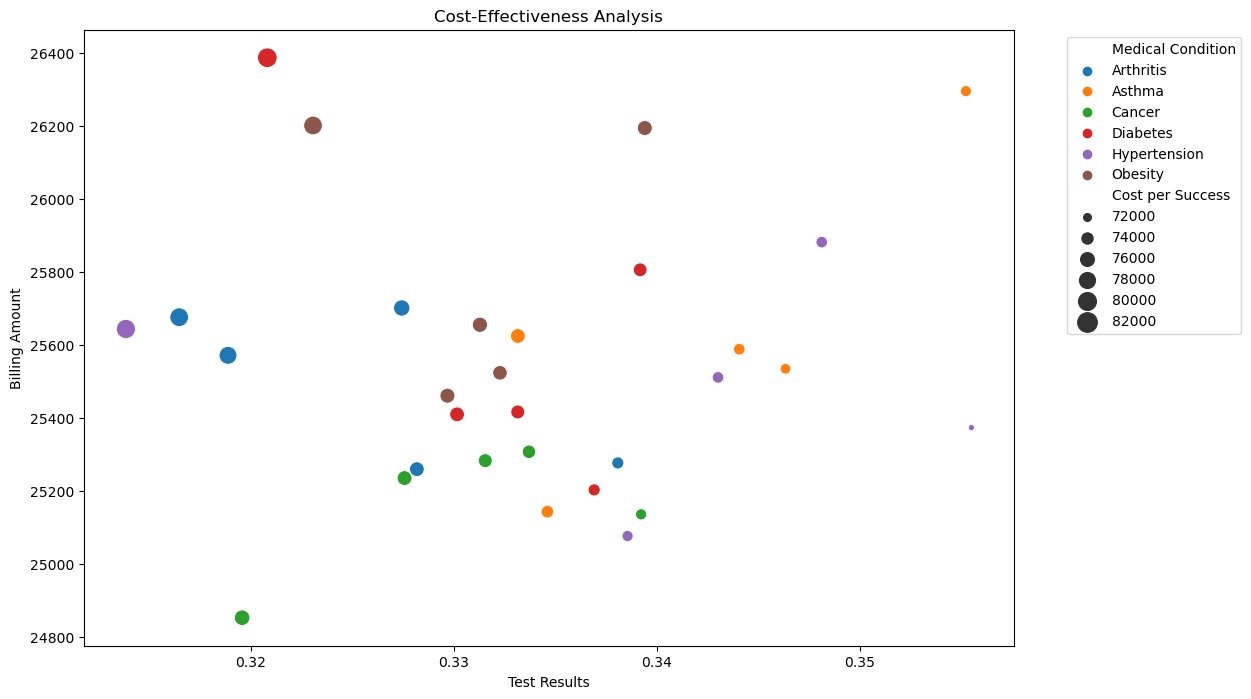

In [31]:
# Visualize
plt.figure(figsize=(12,8))
sns.scatterplot(data=cost_effectiveness, x='Test Results', y='Billing Amount',
                hue='Medical Condition', size='Cost per Success', sizes=(20, 200))
plt.title('Cost-Effectiveness Analysis')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()